In [1]:
pwd

'/Users/iw2g24/PycharmProjects/SSH_project/mca_shared_izzy'

In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
import numpy as np
import xarray as xr
from pyproj import Proj, Transformer
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import griddata
import xeofs as xe
from geometry_izzyv1 import grad_sphere
from regression_izzyv1 import linregress_3D
import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
import warnings
import os
warnings.filterwarnings('ignore')
from matplotlib.ticker import MultipleLocator




In [4]:
# constant
rho_a = 1.225 # air density kg m-3

Cd = 1.5e-3 # drag coeff

In [5]:
gridtype = 'remapcon'

In [6]:
# dot dataset
path = '/Users/iw2g24/PycharmProjects/SSH_project/'
print(path)
ds = xr.open_dataset(path + 'Data/dot_all_30bmedian_goco05c_sig3_1.nc')
print(ds)
# ERA5 remap dataset
ds_era5 = xr.open_dataset(path + 'Data/ERA5_u10v10_Antartica_2000-2023_' + gridtype + '.nc')

/Users/iw2g24/PycharmProjects/SSH_project/
<xarray.Dataset> Size: 109MB
Dimensions:          (longitude: 360, latitude: 64, time: 196, edge_lat: 65,
                      edge_lon: 361)
Coordinates:
  * longitude        (longitude) float64 3kB -179.5 -178.5 ... 178.5 179.5
  * latitude         (latitude) float64 512B -81.75 -81.25 ... -50.75 -50.25
  * time             (time) datetime64[ns] 2kB 2002-07-01 ... 2018-10-01
  * edge_lat         (edge_lat) float64 520B -82.0 -81.5 -81.0 ... -50.5 -50.0
  * edge_lon         (edge_lon) float64 3kB -180.0 -179.0 -178.0 ... 179.0 180.0
Data variables:
    dot              (longitude, latitude, time) float64 36MB ...
    ug               (longitude, latitude, time) float64 36MB ...
    vg               (longitude, latitude, time) float64 36MB ...
    land_mask        (longitude, latitude) float64 184kB ...
    intersat_offset  float64 8B ...
Attributes:
    history:      Created 08/01/2022, 00:5223
    description:  ENVISAT + CryoSat2 altimetry 

<xarray.Dataset> Size: 949kB
Dimensions:                          (time: 1, y: 332, x: 316)
Coordinates:
  * time                             (time) datetime64[ns] 8B 2003-02-01
  * x                                (x) float64 3kB -3.938e+06 ... 3.938e+06
  * y                                (y) float64 3kB 4.338e+06 ... -3.938e+06
Data variables:
    cdr_seaice_conc_monthly          (time, y, x) float32 420kB ...
    cdr_seaice_conc_monthly_stdev    (time, y, x) float32 420kB ...
    cdr_seaice_conc_monthly_qa_flag  (time, y, x) uint8 105kB ...
    crs                              int32 4B ...
Attributes: (12/46)
    Conventions:               CF-1.11, ACDD-1.3
    date_created:              2024-11-20T21:35:53Z
    time_coverage_start:       2003-02-01T00:00:00Z
    time_coverage_end:         2003-02-28T23:59:59Z
    time_coverage_resolution:  P1M
    time_coverage_duration:    P1M
    ...                        ...
    geospatial_lat_min:        -90.0
    geospatial_lat_max:        

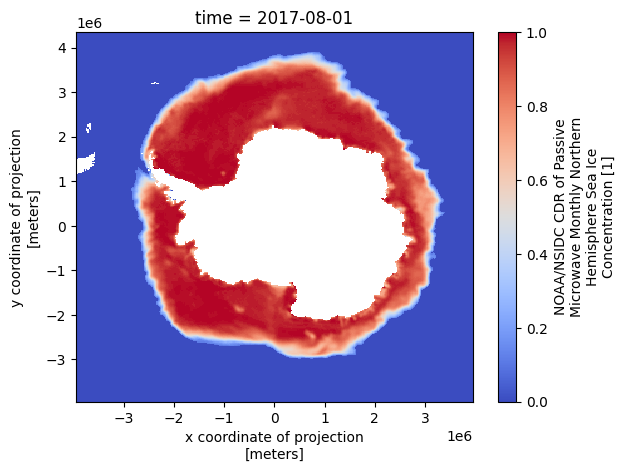

(316,)
(332,)


In [7]:
#sea ice drift data from nsidc
directory = "/Users/iw2g24/PycharmProjects/SSH_project/mca_shared_izzy/si_conc_NOAA_G02202_V5/"
ds_example = xr.open_dataset(directory + 'sic_pss25_200302_F13_v05r00.nc')
print(ds_example)
print(ds_example['x'])

ds_example2 = xr.open_dataset(directory + 'sic_pss25_201708_F17_v05r00.nc')
print(ds_example2)
print(ds_example2['x'])

variable_name = "cdr_seaice_conc_monthly"

# Extract the data array for plotting
data_to_plot = ds_example2[variable_name]
print("plotted data size",data_to_plot.shape)

# Plot using xarray's built-in method
data_to_plot.plot(cmap="coolwarm")  # Replace 'viridis' with your preferred color map
#plt.title(f"{variable_name} at time {ds_example['time']}")
plt.show()

print(ds_example2["x"].shape)
print(ds_example2["y"].shape)

In [8]:
print(ds_example2["cdr_seaice_conc_monthly"].attrs)

{'long_name': 'NOAA/NSIDC CDR of Passive Microwave Monthly Northern Hemisphere Sea Ice Concentration', 'standard_name': 'sea_ice_area_fraction', 'coverage_content_type': 'image', 'units': '1', 'valid_range': array([  0, 100], dtype=uint8), 'grid_mapping': 'crs'}


In [9]:
print(ds_example2.variables)


Frozen({'cdr_seaice_conc_monthly': <xarray.Variable (time: 1, y: 332, x: 316)> Size: 420kB
[104912 values with dtype=float32]
Attributes:
    long_name:              NOAA/NSIDC CDR of Passive Microwave Monthly North...
    standard_name:          sea_ice_area_fraction
    coverage_content_type:  image
    units:                  1
    valid_range:            [  0 100]
    grid_mapping:           crs, 'cdr_seaice_conc_monthly_stdev': <xarray.Variable (time: 1, y: 332, x: 316)> Size: 420kB
[104912 values with dtype=float32]
Attributes:
    long_name:     NOAA/NSIDC CDR of Passive Microwave Monthly Northern Hemis...
    valid_range:   [0. 1.]
    grid_mapping:  crs
    units:         1, 'cdr_seaice_conc_monthly_qa_flag': <xarray.Variable (time: 1, y: 332, x: 316)> Size: 105kB
[104912 values with dtype=uint8]
Attributes:
    long_name:              NOAA/NSIDC CDR of Passive Microwave Monthly North...
    standard_name:          status_flag
    coverage_content_type:  image
    units:      

In [10]:
ds_check = xr.open_dataset('sic_NOAA_G02202_V5.nc')
print(ds_check)

<xarray.Dataset> Size: 517MB
Dimensions:                          (time: 548, y: 332, x: 316)
Coordinates:
  * time                             (time) datetime64[ns] 4kB 1978-11-01 ......
  * x                                (x) float64 3kB -3.938e+06 ... 3.938e+06
  * y                                (y) float64 3kB 4.338e+06 ... -3.938e+06
Data variables:
    cdr_seaice_conc_monthly          (time, y, x) float32 230MB ...
    cdr_seaice_conc_monthly_stdev    (time, y, x) float32 230MB ...
    cdr_seaice_conc_monthly_qa_flag  (time, y, x) uint8 57MB ...
    crs                              (time) int32 2kB ...
Attributes: (12/46)
    Conventions:               CF-1.11, ACDD-1.3
    date_created:              2024-11-20T21:28:10Z
    time_coverage_start:       1978-11-01T00:00:00Z
    time_coverage_end:         1978-11-30T23:59:59Z
    time_coverage_resolution:  P1M
    time_coverage_duration:    P1M
    ...                        ...
    geospatial_lat_min:        -90.0
    geospatial

In [11]:
ds_nsidc_conc = xr.open_dataset('sic_NOAA_G02202_V5.nc')
print(ds_nsidc_conc)

<xarray.Dataset> Size: 517MB
Dimensions:                          (time: 548, y: 332, x: 316)
Coordinates:
  * time                             (time) datetime64[ns] 4kB 1978-11-01 ......
  * x                                (x) float64 3kB -3.938e+06 ... 3.938e+06
  * y                                (y) float64 3kB 4.338e+06 ... -3.938e+06
Data variables:
    cdr_seaice_conc_monthly          (time, y, x) float32 230MB ...
    cdr_seaice_conc_monthly_stdev    (time, y, x) float32 230MB ...
    cdr_seaice_conc_monthly_qa_flag  (time, y, x) uint8 57MB ...
    crs                              (time) int32 2kB ...
Attributes: (12/46)
    Conventions:               CF-1.11, ACDD-1.3
    date_created:              2024-11-20T21:28:10Z
    time_coverage_start:       1978-11-01T00:00:00Z
    time_coverage_end:         1978-11-30T23:59:59Z
    time_coverage_resolution:  P1M
    time_coverage_duration:    P1M
    ...                        ...
    geospatial_lat_min:        -90.0
    geospatial

In [12]:
data_to_plot = ds_nsidc_conc["cdr_seaice_conc_monthly"]
print("xgrid shape:", ds_nsidc_conc["x"].shape)
print("ygrid shape:", ds_nsidc_conc["y"].shape)
print("Data to plot shape:", data_to_plot.isel(time = 0).shape)


xgrid shape: (316,)
ygrid shape: (332,)
Data to plot shape: (332, 316)


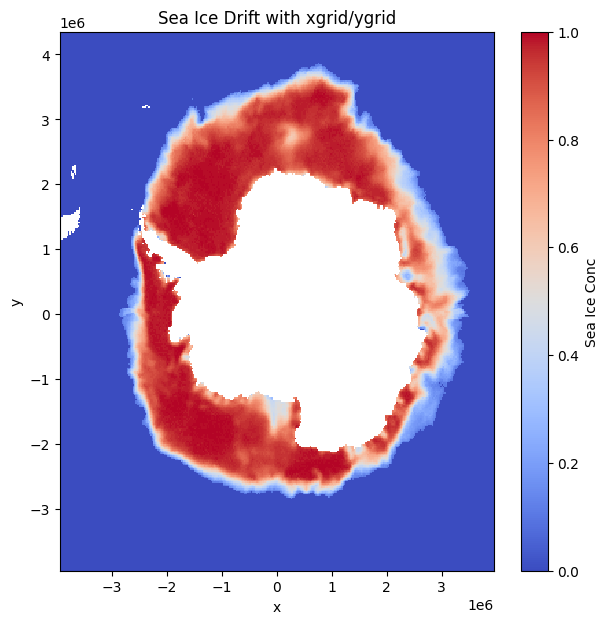

In [13]:
# Plot sea ice conc using x and y coordinates
data_to_plot = ds_nsidc_conc["cdr_seaice_conc_monthly"]

plt.figure(figsize=(7,7))
plt.pcolormesh(
    ds_nsidc_conc["x"],
    ds_nsidc_conc["y"],
    data_to_plot.isel(time=0),
    cmap="coolwarm",
    shading="auto"
)
plt.colorbar(label="Sea Ice Conc")
plt.title("Sea Ice Drift with xgrid/ygrid")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


In [14]:
print("Data shape:", ds_nsidc_conc["cdr_seaice_conc_monthly"].shape)
print("Longitude shape:", ds_nsidc_conc["x"].shape)
print("Latitude shape:", ds_nsidc_conc["y"].shape)


Data shape: (548, 332, 316)
Longitude shape: (316,)
Latitude shape: (332,)


In [15]:
print(ds_nsidc_conc["x"])

<xarray.DataArray 'x' (x: 316)> Size: 3kB
array([-3937500., -3912500., -3887500., ...,  3887500.,  3912500.,  3937500.])
Coordinates:
  * x        (x) float64 3kB -3.938e+06 -3.912e+06 ... 3.912e+06 3.938e+06
Attributes:
    standard_name:          projection_x_coordinate
    long_name:              x coordinate of projection
    units:                  meters
    axis:                   X
    valid_range:            [-3950000.  3950000.]
    coverage_content_type:  coordinate


In [16]:
print(ds_nsidc_conc.values)
print(ds_nsidc_conc['y'].shape)
print(ds_nsidc_conc['x'].shape)

<bound method Mapping.values of <xarray.Dataset> Size: 517MB
Dimensions:                          (time: 548, y: 332, x: 316)
Coordinates:
  * time                             (time) datetime64[ns] 4kB 1978-11-01 ......
  * x                                (x) float64 3kB -3.938e+06 ... 3.938e+06
  * y                                (y) float64 3kB 4.338e+06 ... -3.938e+06
Data variables:
    cdr_seaice_conc_monthly          (time, y, x) float32 230MB ...
    cdr_seaice_conc_monthly_stdev    (time, y, x) float32 230MB ...
    cdr_seaice_conc_monthly_qa_flag  (time, y, x) uint8 57MB ...
    crs                              (time) int32 2kB ...
Attributes: (12/46)
    Conventions:               CF-1.11, ACDD-1.3
    date_created:              2024-11-20T21:28:10Z
    time_coverage_start:       1978-11-01T00:00:00Z
    time_coverage_end:         1978-11-30T23:59:59Z
    time_coverage_resolution:  P1M
    time_coverage_duration:    P1M
    ...                        ...
    geospatial_lat_

In [17]:
#converting x and y to lat and lon
# Extract x and y coordinates
x = ds_nsidc_conc['x'].values  # Get NumPy array of x coordinates
y = ds_nsidc_conc['y'].values  # Get NumPy array of y coordinates

# Define the projection (choose North or South)
proj_stere = Proj("+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +a=6378273 +b=6356889.449 +units=m +no_defs")

# Define target WGS84 (lat/lon) projection
proj_wgs84 = Proj("epsg:4326")

# Create a 2D grid of x and y coordinates
X, Y = np.meshgrid(x, y)

# Define the stereographic projection (SH)
proj_stere = Proj("+proj=stere +lat_0=-90 +lat_ts=-70 +lon_0=0 +k=1 +x_0=0 +y_0=0 +a=6378273 +b=6356889.449 +units=m +no_defs")


# Define target WGS84 projection
proj_wgs84 = Proj("epsg:4326")

# Use Transformer for efficient vectorized transformation
transformer = Transformer.from_proj(proj_stere, proj_wgs84, always_xy=True)

# Convert entire 2D grid of (X, Y) to (lon, lat)
lon, lat = transformer.transform(X, Y)

# Add lat/lon to dataset
ds_nsidc_conc.coords['lon'] = (('y', 'x'), lon)
ds_nsidc_conc.coords['lat'] = (('y', 'x'), lat)

print(ds_nsidc_conc)
print(ds_nsidc_conc['lon'].max(), ds_nsidc_conc['lon'].min())
print(ds_nsidc_conc['lat'].max(), ds_nsidc_conc['lat'].min())


<xarray.Dataset> Size: 519MB
Dimensions:                          (time: 548, y: 332, x: 316)
Coordinates:
  * time                             (time) datetime64[ns] 4kB 1978-11-01 ......
  * x                                (x) float64 3kB -3.938e+06 ... 3.938e+06
  * y                                (y) float64 3kB 4.338e+06 ... -3.938e+06
    lon                              (y, x) float64 839kB -42.23 ... 135.0
    lat                              (y, x) float64 839kB -39.36 ... -41.58
Data variables:
    cdr_seaice_conc_monthly          (time, y, x) float32 230MB ...
    cdr_seaice_conc_monthly_stdev    (time, y, x) float32 230MB ...
    cdr_seaice_conc_monthly_qa_flag  (time, y, x) uint8 57MB ...
    crs                              (time) int32 2kB ...
Attributes: (12/46)
    Conventions:               CF-1.11, ACDD-1.3
    date_created:              2024-11-20T21:28:10Z
    time_coverage_start:       1978-11-01T00:00:00Z
    time_coverage_end:         1978-11-30T23:59:59Z
    t

In [18]:
print(ds_nsidc_conc['time'].dtype)

datetime64[ns]


In [19]:
time_nsidc = ds_nsidc_conc['time'].values
print("nsidc conc time", time_nsidc[284],time_nsidc[479])

nsidc conc time 2002-07-01T00:00:00.000000000 2018-10-01T00:00:00.000000000


In [20]:
#reorder ds_nsidc_conc  to have time_new, lat, lon

# Open the dataset
ds_nsidc_conc = xr.open_dataset("nsidc_conc2.nc")

# Step 1: Extract lat, lon, and sea ice concentration
lat_nsidc = ds_nsidc_conc['lat'].values  # Shape (y, x)
lon_nsidc = ds_nsidc_conc['lon'].values  # Shape (y, x)
time_new = ds_nsidc_conc['time_new'].values  # Shape (time_new)

# Step 2: Flatten the lat and lon arrays into 1D arrays
lat_flat = lat_nsidc.flatten()
lon_flat = lon_nsidc.flatten()

# Step 3: Reshape the variable (e.g., 'sea_ice_conc') to match the flattened grid
var = ds_check['cdr_seaice_conc_monthly'].values  # Shape (time_new, tdim, y, x)

# Remove 'tdim' dimension by squeezing it
var_squeezed = var[:, :, :]  # Shape becomes (time_new, y, x)

# Flatten 'y' and 'x' into a single dimension
var_flat = var_squeezed.reshape((var_squeezed.shape[0], -1))  # Shape (time_new, y*x)

# Step 4: Create a new dataset with dimensions (time_new, lat, lon)
ds_reordered = xr.Dataset(
    data_vars={
        'si_conc': (['time_new', 'points'], var_flat)  # Data flattened
    },
    coords={
        'time_new': time_new,      # Time dimension
        'lat': ('points', lat_flat),  # 1D lat coordinate
        'lon': ('points', lon_flat)   # 1D lon coordinate
    }
)

# Step 5: Verify the new dataset
print(ds_reordered)

# Step 6: Save the new dataset
output_file = "reordered_sea_ice_concentration.nc"
ds_reordered.to_netcdf(output_file)
print(f"Reordered dataset saved to: {output_file}")


<xarray.Dataset> Size: 232MB
Dimensions:   (time_new: 548, points: 104912)
Coordinates:
  * time_new  (time_new) datetime64[ns] 4kB 1978-11-01 1978-12-01 ... 2024-06-01
    lat       (points) float64 839kB -39.36 -39.49 -39.62 ... -41.72 -41.58
    lon       (points) float64 839kB -42.23 -42.05 -41.87 ... 135.4 135.2 135.0
Dimensions without coordinates: points
Data variables:
    si_conc   (time_new, points) float32 230MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Reordered dataset saved to: reordered_sea_ice_concentration.nc


In [21]:
print(f"Number of points: {lat_flat.shape[0]} (should be equal to y * x)")
print(f"Sea Ice Concentration reshaped to: {var_flat.shape}")
print(332*316)

Number of points: 104912 (should be equal to y * x)
Sea Ice Concentration reshaped to: (548, 104912)
104912


In [22]:
# change coordinates from (lon,lat,time) to (time,lat,lon) as ERA5
lon_dot = ds['longitude'].values; lat_dot = ds['latitude'].values
dot_all = ds['dot'].values
dot = np.zeros((dot_all.shape[2], dot_all.shape[1], dot_all.shape[0]))
for t in range(0,dot_all.shape[2]):
    for i in range(0,dot_all.shape[1]):
        for j in range(0,dot_all.shape[0]):
            dot[t,i,j] = dot_all[j,i,t].copy()
seamask = dot[0].copy()/dot[0]
seamask[seamask == 0] = np.nan
del dot_all

In [23]:
# make lon lat 2d
llon = np.zeros((dot.shape[1],dot.shape[2]))
for i in range(0,dot.shape[1]):
    llon[i,:] = lon_dot
llat = np.zeros((dot.shape[1],dot.shape[2]))
for i in range(0,dot.shape[2]):
    llat[:,i] = lat_dot

In [24]:
print(dot.shape)
print(llon.shape)
print(llat.shape)
print(dot[0].shape)

(196, 64, 360)
(64, 360)
(64, 360)
(64, 360)


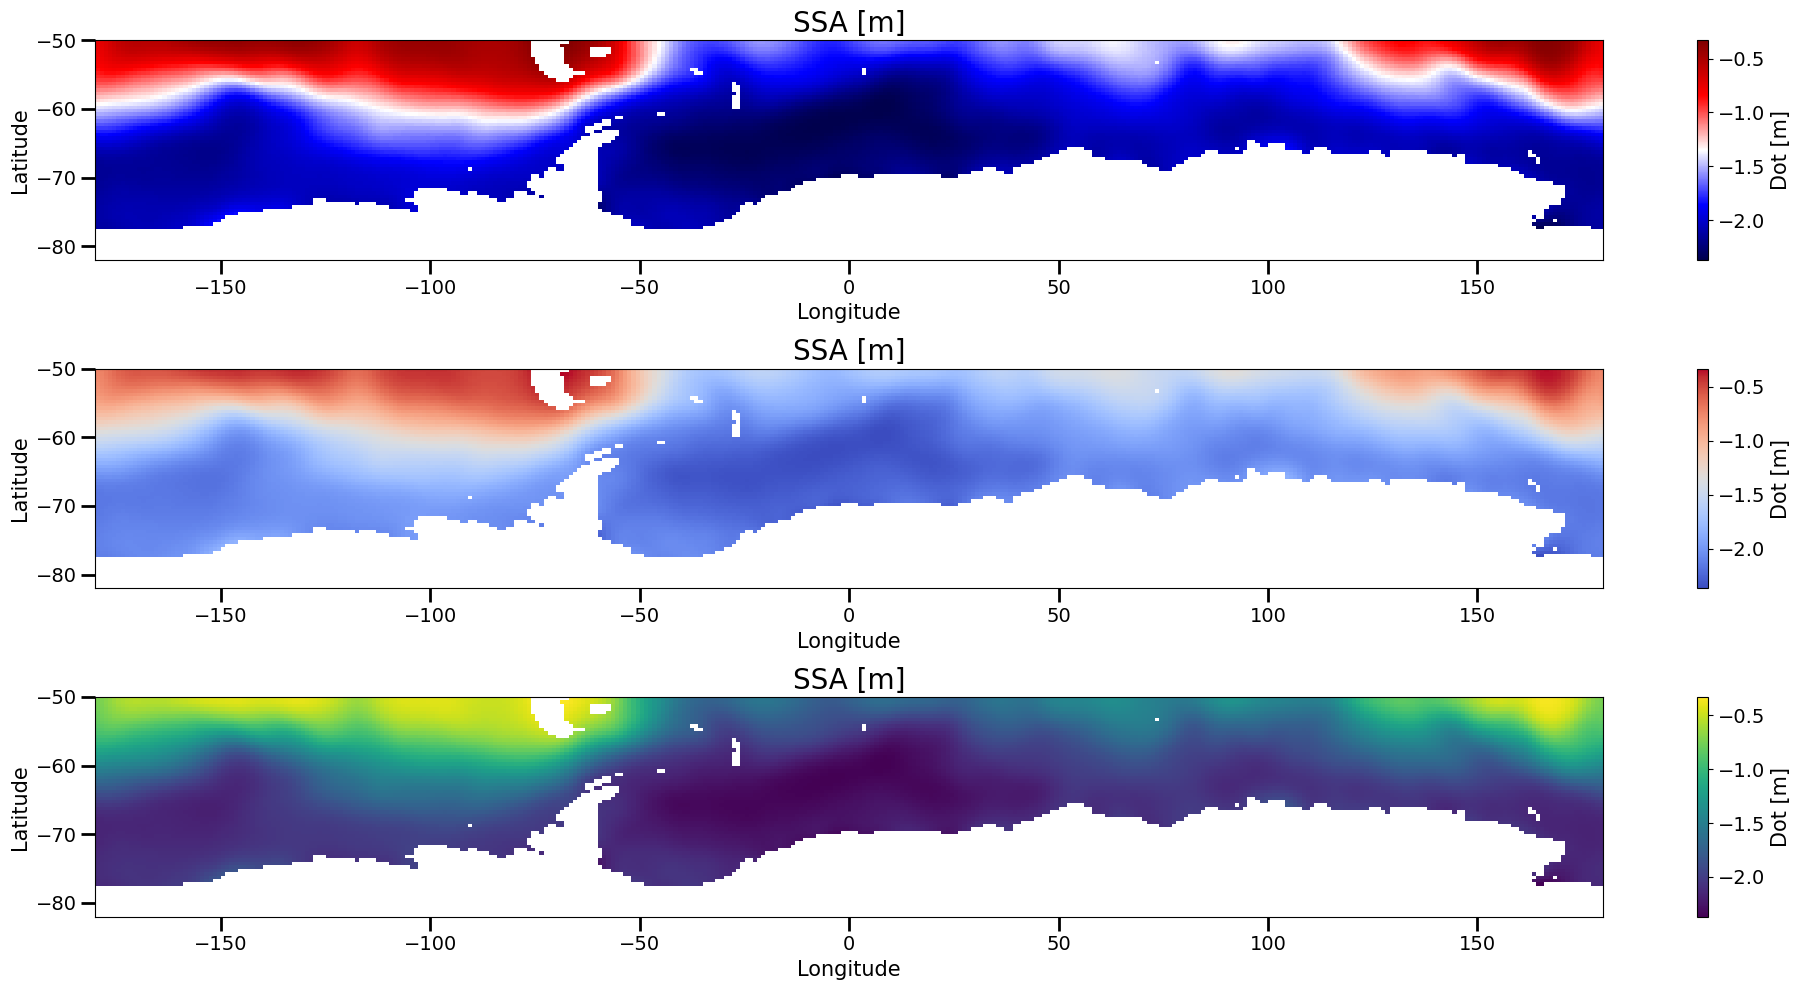

In [25]:
#plot dot with different colour schemes
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 10))

pc1 = axes[0].pcolormesh(llon,llat,dot[0], cmap='seismic')
axes[0].tick_params(axis='both', which='major', length=10, width=2, labelsize=14)
axes[0].set_title('SSA [m]', fontsize=20)
axes[0].set_xlabel('Longitude', fontsize=15)
axes[0].set_ylabel('Latitude', fontsize=15)
cbar1 = fig.colorbar(pc1, ax=axes[0])
cbar1.set_label('Dot [m]', fontsize=15)
cbar1.ax.tick_params(labelsize=14)

pc2 = axes[1].pcolormesh(llon,llat,dot[0], cmap='coolwarm')
axes[1].tick_params(axis='both', which='major', length=10, width=2, labelsize=14)
axes[1].set_title('SSA [m]', fontsize=20)
axes[1].set_xlabel('Longitude', fontsize=15)
axes[1].set_ylabel('Latitude', fontsize=15)
cbar2 = fig.colorbar(pc2, ax=axes[1])
cbar2.set_label('Dot [m]', fontsize=15)
cbar2.ax.tick_params(labelsize=14)

pc3 = axes[2].pcolormesh(llon,llat,dot[0], cmap='viridis')
axes[2].tick_params(axis='both', which='major', length=10, width=2, labelsize=14)
axes[2].set_title('SSA [m]', fontsize=20)
axes[2].set_xlabel('Longitude', fontsize=15)
axes[2].set_ylabel('Latitude', fontsize=15)
cbar3 = fig.colorbar(pc3, ax=axes[2])
cbar3.set_label('Dot [m]', fontsize=15)
cbar3.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.show()

In [26]:
# time
time_era5 = ds_era5['time'].values
time_dot = ds['time'].values
time_nsidc = ds_nsidc_conc['time_new'].values

In [27]:
time_dot_array = np.array(time_dot, dtype='datetime64[ns]')
time_nsidc_array = np.array(time_nsidc, dtype='datetime64[ns]')

indices_dot_nsidc = np.where(np.isin(time_nsidc_array, time_dot_array))
print(indices_dot_nsidc)

(array([284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296,
       297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309,
       310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322,
       323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335,
       336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348,
       349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361,
       362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374,
       375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387,
       388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400,
       401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413,
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 4

In [28]:
#print(time_era5)
print("dot time", time_dot[0],time_dot[-1])
print("era5 time", time_era5[30],time_era5[225])
print("nsidc conc time", time_nsidc[284],time_nsidc[479])

dot time 2002-07-01T00:00:00.000000000 2018-10-01T00:00:00.000000000
era5 time 2002-07-01T00:00:00.000000000 2018-10-01T00:00:00.000000000
nsidc conc time 2002-07-01T00:00:00.000000000 2018-10-01T00:00:00.000000000


In [29]:
tstart_era5 = 30
tend_era5 = 226 # +1 respect cell above

tstart_nsidc = 284
tend_nsidc = 480 #+1 respect cell above

In [30]:
# select sea ice concentration
seaice_concentration = ds_nsidc_conc['cdr_seaice_conc_monthly'][tstart_nsidc:tend_nsidc].values
print(seaice_concentration.shape)
print(seaice_concentration.max())

(196, 1, 332, 316)
2.54


In [31]:
# DE-TREND DOT

In [32]:
# linear regression in time on each grid point
n,slope,intercept,p_val,r_square,rmse = linregress_3D(dot)
# remove trend for dot
xt = np.zeros(dot.shape)
for t in range(0,dot.shape[0]):
    xt[t] = t
dot_detrended = dot - (slope*xt + intercept)

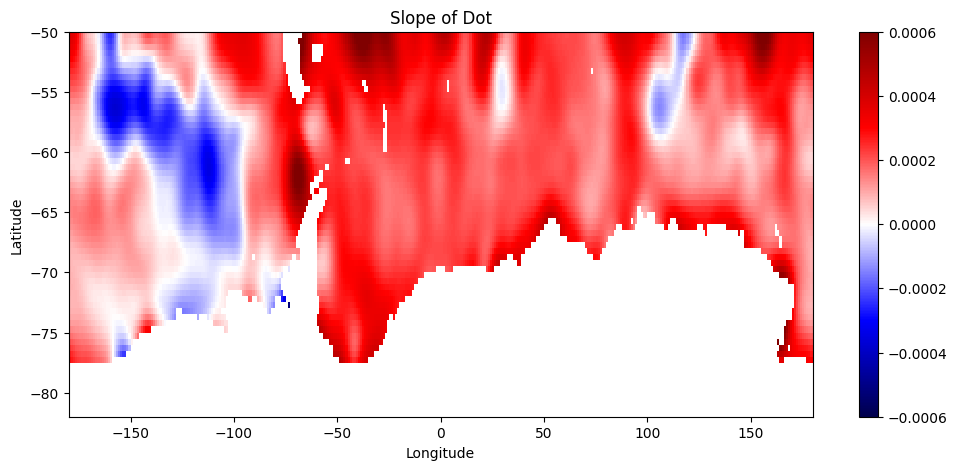

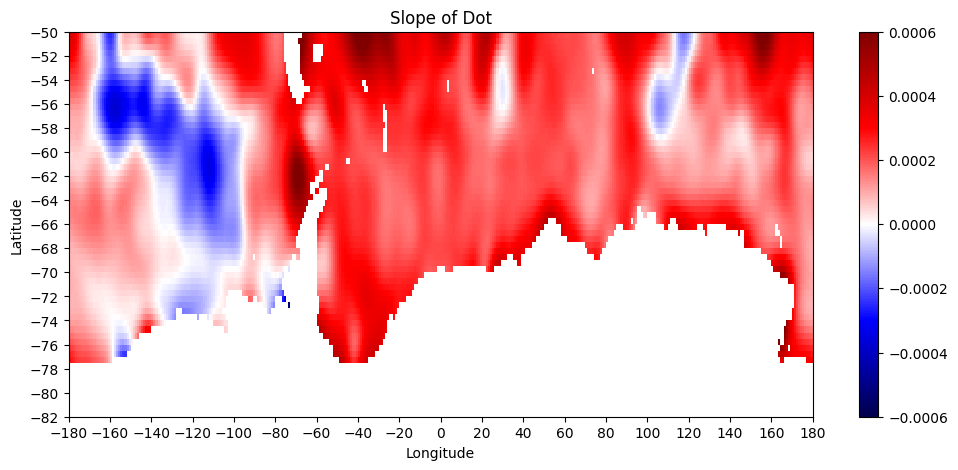

In [43]:
plt.figure(figsize=(12,5))
plt.pcolormesh(llon, llat, slope, vmin=-6e-4, vmax=6e-4, cmap='seismic')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Slope of Dot')
plt.colorbar()

# Set y-axis tick interval
tick_interval = 5  # Adjust as needed
plt.gca().yaxis.set_major_locator(MultipleLocator(tick_interval))

plt.show()
plt.figure(figsize=(12,5))
plt.pcolormesh(llon, llat, slope, vmin=-6e-4, vmax=6e-4, cmap='seismic')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.gca().yaxis.set_major_locator(MultipleLocator(2))
plt.gca().xaxis.set_major_locator(MultipleLocator(20))
plt.title('Slope of Dot')
plt.colorbar()


In [62]:
print(llat)
print(slope)

[[-81.75 -81.75 -81.75 ... -81.75 -81.75 -81.75]
 [-81.25 -81.25 -81.25 ... -81.25 -81.25 -81.25]
 [-80.75 -80.75 -80.75 ... -80.75 -80.75 -80.75]
 ...
 [-51.25 -51.25 -51.25 ... -51.25 -51.25 -51.25]
 [-50.75 -50.75 -50.75 ... -50.75 -50.75 -50.75]
 [-50.25 -50.25 -50.25 ... -50.25 -50.25 -50.25]]
[[       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 ...
 [0.00035096 0.00034826 0.00033341 ... 0.00032059 0.0003326  0.00034429]
 [0.0003673  0.00036472 0.00034894 ... 0.00033456 0.00034747 0.00035998]
 [0.00037583 0.00037336 0.00035716 ... 0.00034186 0.00035523 0.00036816]]


Transition to NaN occurs at latitude: -81.75°
0.0006220528360365348
The latitude corresponding to slope value 0.0006220528 is: -81.75°


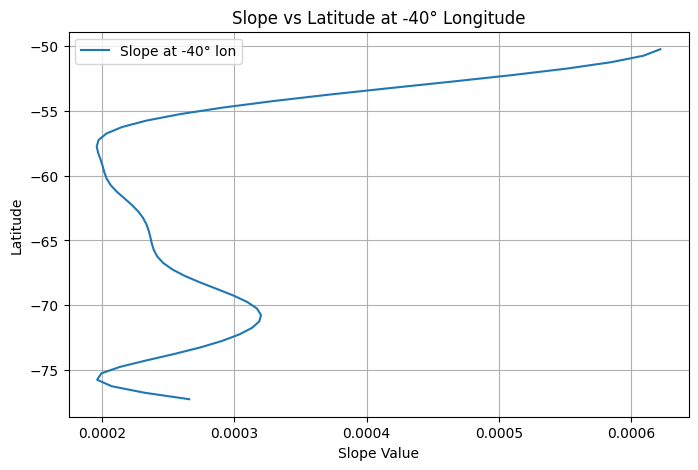

In [59]:
target_longitude = -40

# Find the index of the closest longitude value in llon
lon_idx = np.argmin(np.abs(llon[0, :] - target_longitude))  # Assuming llon is 2D

# Extract the latitudes and corresponding slope values at this longitude
lat_values = llat[:, lon_idx]
slope_values = slope[:, lon_idx]

# Find the index where NaN first appears
nan_idx = np.where(np.isnan(slope_values))[0]

if nan_idx.size > 0:
    transition_lat = lat_values[nan_idx[0]]
    print(f"Transition to NaN occurs at latitude: {transition_lat:.2f}°")
else:
    print("No NaN transition found at this longitude.")

valid_slope = slope_values[~np.isnan(slope_values)]
print(np.max(valid_slope))
specific_slope_value = np.max(valid_slope)
# Find the index where the specific slope value occurs (exact match or close match)
slope_idx = np.argmin(np.abs(slope_values - specific_slope_value))

# Get the corresponding latitude at this index
corresponding_lat = lat_values[slope_idx]
print(f"The latitude corresponding to slope value {specific_slope_value:.10f} is: {corresponding_lat:.2f}°")


plt.figure(figsize=(8,5))
plt.plot(slope_values, lat_values, label=f"Slope at {target_longitude}° lon")
#plt.axhline(last_valid_idx, color='r', linestyle='--', label=f"End of Slope ({transition_lat:.2f}°)")
plt.xlabel("Slope Value")
plt.ylabel("Latitude")
plt.legend()
plt.title(f"Slope vs Latitude at {target_longitude}° Longitude")
plt.grid()
plt.show()



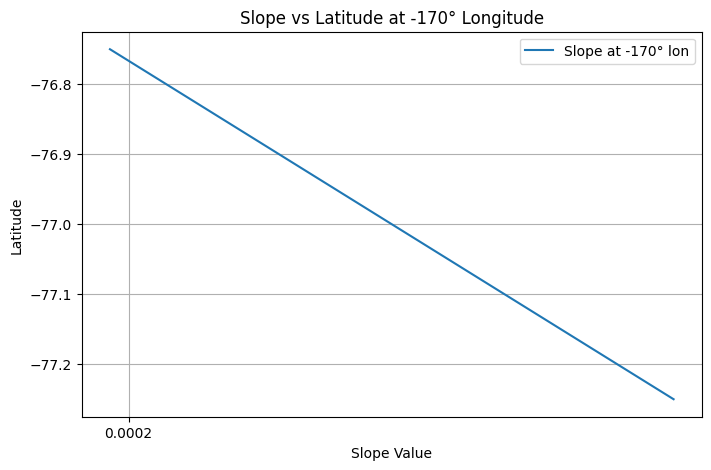

In [88]:
import numpy as np
import matplotlib.pyplot as plt

# Define the longitude you want to check
target_longitude = -170  # Change this to your desired longitude

# Find the index of the closest longitude value in llon
lon_idx = np.argmin(np.abs(llon[0, :] - target_longitude))  # Assuming llon is 2D

# Extract the latitudes and corresponding slope values at this longitude
lat_values = llat[:, lon_idx]
slope_values = slope[:, lon_idx]

mask = lat_values <= -76.7

lat_values = lat_values[mask]
slope_values = slope_values[mask]

# Mask NaN values
valid_indices = ~np.isnan(slope_values)  # Boolean array where values are not NaN
lat_values = lat_values[valid_indices]  # Filter latitudes where slope_values are valid
slope_values = slope_values[valid_indices]  # Filter slope values to remove NaNs

# Plot the slope vs latitude
plt.figure(figsize=(8,5))
plt.plot(slope_values, lat_values, label=f"Slope at {target_longitude}° lon")
plt.xlabel("Slope Value")
plt.ylabel("Latitude")
plt.legend()
plt.title(f"Slope vs Latitude at {target_longitude}° Longitude")
plt.gca().xaxis.set_major_locator(MultipleLocator(0.0001))  # Change x-axis grid spacing
plt.gca().yaxis.set_major_locator(MultipleLocator(0.1))    # Change y-axis grid spacing

plt.grid()
# Show the plot
plt.show()


In [34]:
1dot_final = dot_detrended.copy()

In [35]:
seaice_concentration = ds_nsidc_conc['cdr_seaice_conc_monthly'][tstart_nsidc:tend_nsidc].values
print(seaice_concentration.shape)

# Assuming 'time_new' is the time coordinate in the dataset
time_values = ds_nsidc_conc['time_new'][tstart_nsidc:tend_nsidc].values
print(time_values.shape)  # To verify the shape


(196, 1, 332, 316)
(196,)


In [36]:
print(seaice_concentration.shape)
print((seaice_concentration).shape[0])
print((seaice_concentration[t,0]).shape)


(196, 1, 332, 316)
196
(332, 316)


In [37]:
#remap data onto dot grid
# Target grid
lon_target = ds['longitude'].values  # (360,)
lat_target = ds['latitude'].values  # (64,)

# Create an empty list to store regridded data
regridded_data_list = []
time_steps_list = []


# Loop through each time step of the original sea ice data
for t in range(seaice_concentration.shape[0]):  # Loop over the time dimension
    # Extracting the sea ice concentration at time t, shape (332, 316)
    seaice = seaice_concentration[t, 0]

    # Coordinates for the original grid
    lon_seaice = lon_nsidc  # (332, 316)
    lat_seaice = lat_nsidc  # (332, 316)

    # Flatten original grid and sea ice data
    points = np.array([lon_seaice.flatten(), lat_seaice.flatten()]).T  # [lon, lat]
    values = seaice.flatten()

    # print(points.shape)
    # print(values.shape)


    # Generate target grid (meshgrid for lon and lat)
    lon_mesh, lat_mesh = np.meshgrid(lon_target, lat_target)  # 2D target grid

    # Interpolate onto the target grid
    seaice_regridded = griddata(points, values, (lon_mesh, lat_mesh), method='linear')

    # Add regridded data to list (append 2D array for this time step)
    regridded_data_list.append(seaice_regridded)

    # Store the corresponding time value
    time_steps_list.append(time_values[t])  # Add the corresponding time step

# Stack the regridded data along the time dimension
regridded_seaice_conc = np.stack(regridded_data_list, axis=0)  # Shape: (time, lat, lon)

# Now you can use regridded_data, and time_steps_list to refer to the time dimension
print(f"Regridded data shape: {regridded_seaice_conc.shape}")
#print(f"Time steps: {time_steps_list}")


KeyboardInterrupt: 

In [121]:
# Create a new xarray DataArray with regridded data
regridded_seaice_da = xr.DataArray(
    regridded_seaice_conc,
    dims=("time", "lat", "lon"),
    coords={
        "time": time_steps_list,  # Assuming time steps are just integers
        "lat": lat_target,  # New latitude grid (64,)
        "lon": lon_target,  # New longitude grid (360,)
    },
    name="seaice_concentration",  # Variable name
)

# Create a Dataset with the regridded DataArray
regridded_seaice_ds = xr.Dataset(
    {"seaice_concentration": regridded_seaice_da}
)

# Print dataset to verify
print(regridded_seaice_ds)


<xarray.Dataset> Size: 36MB
Dimensions:               (time: 196, lat: 64, lon: 360)
Coordinates:
  * time                  (time) datetime64[ns] 2kB 2002-07-01 ... 2018-10-01
  * lat                   (lat) float64 512B -81.75 -81.25 ... -50.75 -50.25
  * lon                   (lon) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
Data variables:
    seaice_concentration  (time, lat, lon) float64 36MB nan 2.54 ... nan nan


<xarray.Dataset> Size: 36MB
Dimensions:               (time: 196, lat: 64, lon: 360)
Coordinates:
  * time                  (time) datetime64[ns] 2kB 2002-07-01 ... 2018-10-01
  * lat                   (lat) float64 512B -81.75 -81.25 ... -50.75 -50.25
  * lon                   (lon) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
Data variables:
    seaice_concentration  (time, lat, lon) float64 36MB nan 2.54 ... nan nan


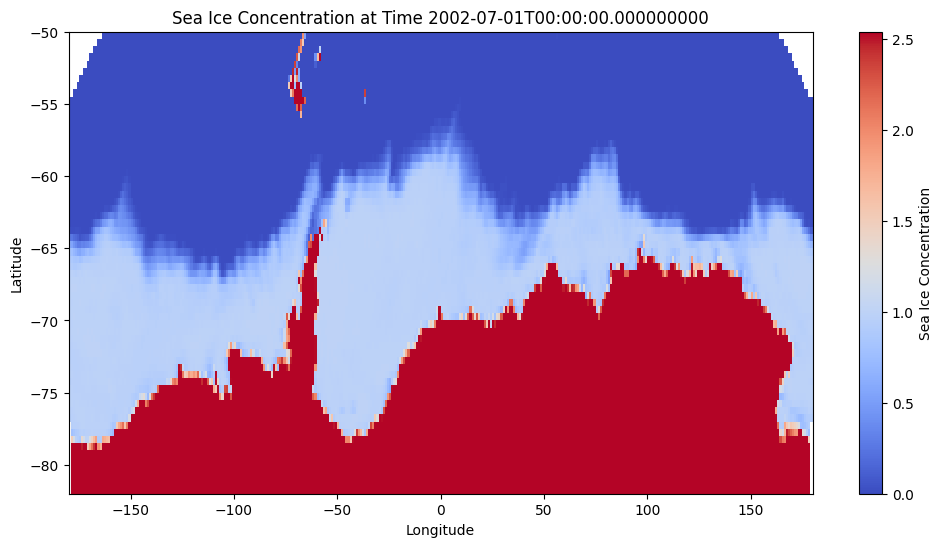

In [122]:
print(regridded_seaice_ds)

# Extract the time, latitude, and longitude coordinates
time_values = regridded_seaice_ds['time'].values
lat_values = regridded_seaice_ds['lat'].values
lon_values = regridded_seaice_ds['lon'].values

# Create a meshgrid for lat/lon coordinates for plotting
lon_mesh, lat_mesh = np.meshgrid(lon_values, lat_values)

# Plot the sea ice concentration at time step 0 (you can change the time index)
plt.figure(figsize=(12, 6))
plt.pcolormesh(llon, llat, regridded_seaice_conc[0], cmap='coolwarm', shading='auto')
plt.colorbar(label='Sea Ice Concentration')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Sea Ice Concentration at Time {time_values[0]}')  # Use time label for title
plt.show()

Original max value in regridded: 2.539999961853028
Max value after masking in regridded_seaice_masked: 1.0


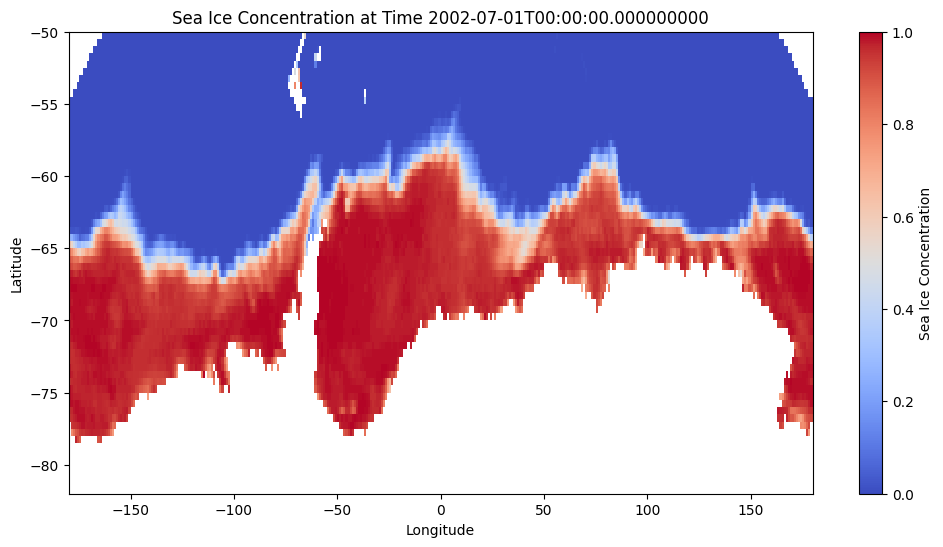

In [123]:

# Mask values > 1
regridded_seaice_filtered = np.where(regridded_seaice_conc >1,  np.nan, regridded_seaice_conc)

# Verify the masking
print("Original max value in regridded:", np.nanmax(regridded_seaice_conc))
print("Max value after masking in regridded_seaice_masked:", np.nanmax(regridded_seaice_filtered))

# Plot the sea ice concentration at time step 0 (you can change the time index)
plt.figure(figsize=(12, 6))
plt.pcolormesh(llon, llat, regridded_seaice_filtered[0], cmap='coolwarm', shading='auto')
plt.colorbar(label='Sea Ice Concentration')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Sea Ice Concentration at Time {time_values[0]}')  # Use time label for title
plt.show()


In [124]:
icemask = regridded_seaice_filtered[0].copy()/regridded_seaice_filtered[0]
icemask[icemask == 0] = np.nan

In [125]:
#apply the icemask
# Apply the mask to the entire seaice_detrended dataset
seaice_masked = regridded_seaice_filtered * icemask[np.newaxis, :, :]

In [126]:
# #detrend seaice conc - not using the masked seaice
# #KEEP THIS CELL BUT COMMENT OR UNCOMMENT THIS/CELL BELOW TO USE SEAICE_MASKED OR NOT ...
# # linear regression in time on each grid point
# n_si,slope_si,intercept_si,p_val_si,r_square_si,rmse_si = linregress_3D(regridded_seaice_filtered)
# # remove trend for dot
# xt_si = np.zeros(regridded_seaice_filtered.shape)
# for t in range(0,regridded_seaice_filtered.shape[0]):
#     xt_si[t] = t
# seaice_detrended = regridded_seaice_filtered - (slope_si*xt_si + intercept_si)
# slope_si = slope_si.squeeze()
#
# # Verify shapes
# print("Longitude shape:", lon_mesh.shape)
# print("Latitude shape:", lat_mesh.shape)
# print("Data shape (slope_si):", slope_si.shape)


In [127]:
#detrend seaice conc - using seaice_masked
# linear regression in time on each grid point
n_si,slope_si,intercept_si,p_val_si,r_square_si,rmse_si = linregress_3D(seaice_masked)
# remove trend for dot
xt_si = np.zeros(seaice_masked.shape)
for t in range(0,seaice_masked.shape[0]):
    xt_si[t] = t
seaice_detrended = seaice_masked - (slope_si*xt_si + intercept_si)
slope_si = slope_si.squeeze()

# Verify shapes
print("Longitude shape:", lon_mesh.shape)
print("Latitude shape:", lat_mesh.shape)
print("Data shape (slope_si):", slope_si.shape)

Longitude shape: (64, 360)
Latitude shape: (64, 360)
Data shape (slope_si): (64, 360)


In [128]:
print('slope range: ', slope_si.min(), slope_si.max(), slope_si.mean(), slope_si.std())

print('seaice conc range:', regridded_seaice_filtered.min(), regridded_seaice_filtered.max())


slope range:  nan nan nan nan
seaice conc range: nan nan


In [129]:
seaice_final = seaice_detrended.copy()

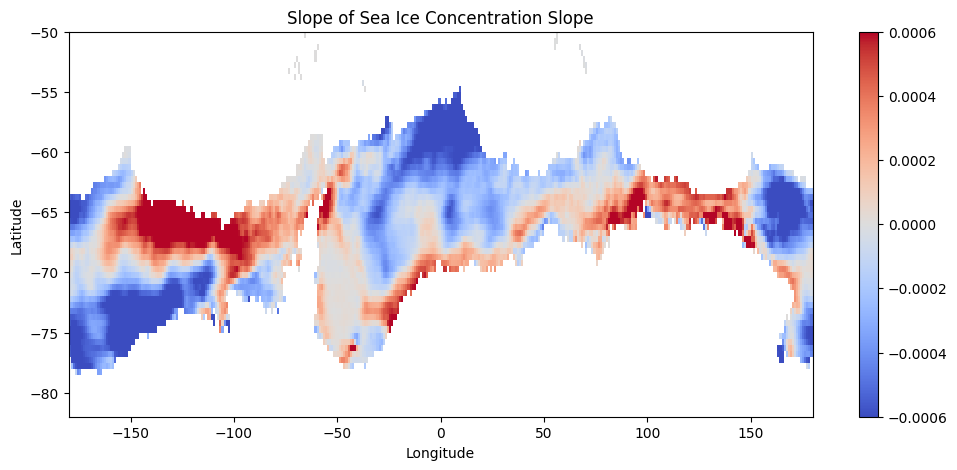

In [130]:
plt.figure(figsize=(12,5))
plt.pcolormesh(llon, llat, slope_si, vmin=-6e-4, vmax=6e-4, cmap='coolwarm')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Slope of Sea Ice Concentration Slope')
plt.colorbar()

In [131]:
#DESEASONAL

In [132]:
#deseasonal for sea ice and dot
months = time_dot.astype('datetime64[M]').astype(int) % 12 + 1

In [133]:
# find and remove seasonality from dot_detrended and seaice_detrended
dot_seas = np.zeros((12,dot.shape[1],dot.shape[2])); seaice_seas = np.zeros((12,dot.shape[1],dot.shape[2]))
for m in range(1,13):
    dot_seas[m-1] = np.nanmean(dot_detrended[np.where(months==m)], axis=0)
    seaice_seas[m-1] = np.nanmean(seaice_detrended[np.where(months==m)], axis=0)

# remove seasonality from dot and sea ice concetration
dot_final = np.zeros(dot_detrended.shape); seaice_final = np.zeros(seaice_detrended.shape)
for i,m in enumerate(months):
    dot_final[i] = dot_detrended[i] - dot_seas[m-1]
    seaice_final[i] = seaice_detrended[i] - seaice_seas[m-1]

In [134]:
print("dot_detrended shape:", dot_detrended.shape)
print("seaice_detrended shape:", seaice_detrended.shape)
print("months shape:", months.shape)


dot_detrended shape: (196, 64, 360)
seaice_detrended shape: (196, 64, 360)
months shape: (196,)


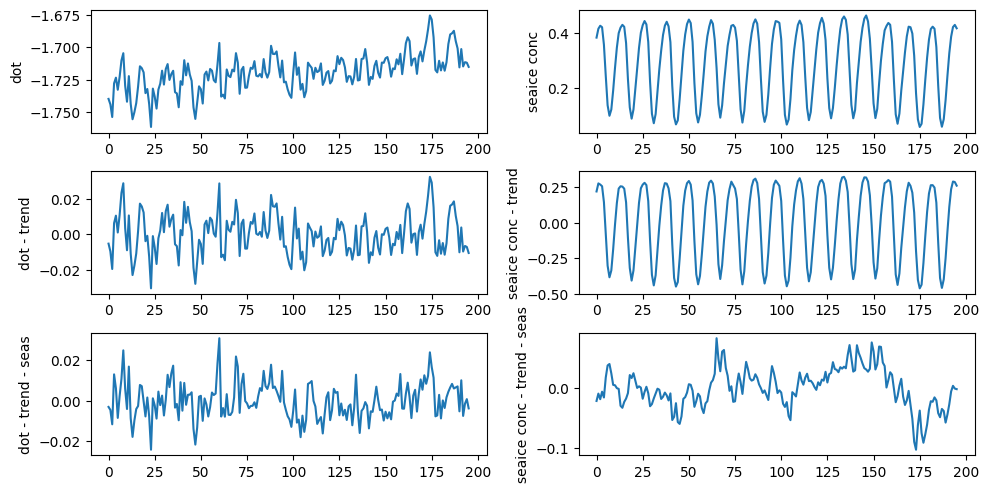

In [135]:
fig = plt.figure(figsize=(10,5))
plt.subplot(3,2,1)
plt.plot(np.nanmean(dot, axis=(1,2)))
plt.ylabel('dot')
plt.subplot(3,2,2)
plt.plot(np.nanmean(regridded_seaice_filtered, axis=(1,2)))
plt.ylabel('seaice conc')
plt.subplot(3,2,3)
plt.plot(np.nanmean(dot_detrended, axis=(1,2)))
plt.ylabel('dot - trend')
plt.subplot(3,2,4)
plt.plot(np.nanmean(seaice_detrended, axis=(1,2)))
plt.ylabel('seaice conc - trend')
plt.subplot(3,2,5)
plt.plot(np.nanmean(dot_final, axis=(1,2)))
plt.ylabel('dot - trend - seas')
plt.subplot(3,2,6)
plt.plot(np.nanmean(seaice_final, axis=(1,2)))
plt.ylabel('seaice conc - trend - seas')

plt.tight_layout()

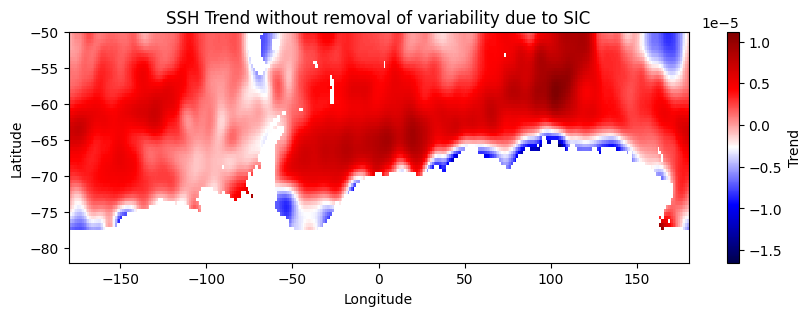

In [136]:
# SSH trends without removing ocean variability due to sea ice concentration
plt.figure(figsize=(10,3))
n,slope,intercept,p_val,r_square,rmse = linregress_3D(dot_final)
plt.pcolormesh(lon_mesh, lat_mesh, slope, cmap='seismic')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('SSH Trend without removal of variability due to SIC')
cbar = plt.colorbar()
cbar.set_label('Trend')

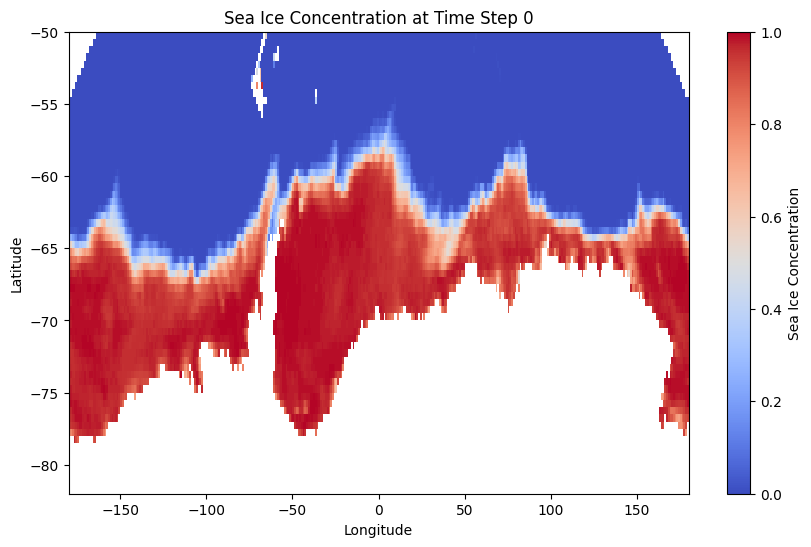

In [137]:
time_step = 0  # You can change this to any index from 0 to 195 (since the shape is (196, 64, 360))

# Extract and plot the masked data for the selected time step
seaice_at_t = regridded_seaice_filtered[time_step]


# Plot the data using pcolormesh
plt.figure(figsize=(10, 6))
plt.pcolormesh( lon_mesh, lat_mesh,seaice_at_t, cmap='coolwarm', shading='auto')
plt.colorbar(label='Sea Ice Concentration')
plt.title(f"Sea Ice Concentration at Time Step {time_step}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [138]:
# MCA

In [139]:
dot_xa = xr.DataArray(dot_final, coords=[time_dot, lat_values, lon_values], dims=["time", "lon", "lat"],)
seaice_xa = xr.DataArray(seaice_final, coords=[time_dot, lat_values, lon_values], dims=["time", "lon", "lat"],)



# print(dot_xa.values)
# print('/n---/n')
# print(seaice_xa.values)

min_value = seaice_xa.where(~seaice_xa.isnull()).min().item()
max_value = seaice_xa.where(~seaice_xa.isnull()).max().item()
print(f"Range of values (excluding NaN): Min = {min_value}, Max = {max_value}")


Range of values (excluding NaN): Min = -0.9004445743067014, Max = 0.929343754111998


In [140]:
total_nans = dot_xa.isnull().sum().item()
print(f"Total NaN values in dot_xa: {total_nans}")

total_nans_seaice = seaice_xa.isnull().sum().item()
print(f"Total NaN values in seaice_xa: {total_nans_seaice}")

total_points_dot = dot_xa.size
print(f"Total data points in dot_xa: {total_points_dot}")

total_points_seaice = seaice_xa.size
print(f"Total data points in seaice_xa: {total_points_seaice}")

print(seaice_xa.shape)
print(dot_xa.shape)



Total NaN values in dot_xa: 1582308
Total NaN values in seaice_xa: 3095884
Total data points in dot_xa: 4515840
Total data points in seaice_xa: 4515840
(196, 64, 360)
(196, 64, 360)


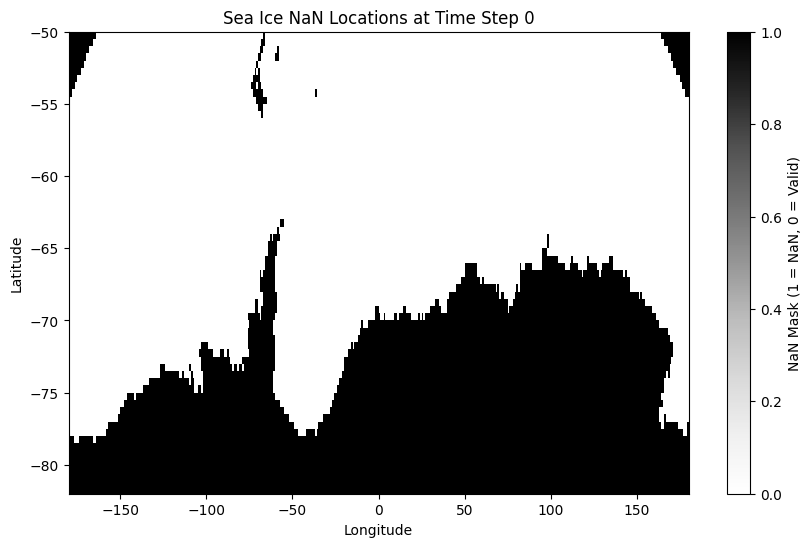

In [141]:
#plot where there are nan values (this is where i created the mask for SIC > 1 earlier)
time_step = 0
# Create a mask where NaN values are True
seaice_nan_mask = np.isnan(regridded_seaice_filtered[time_step])

# Plot the mask using pcolormesh
plt.figure(figsize=(10, 6))
plt.pcolormesh(
    lon_mesh, lat_mesh, seaice_nan_mask,
    cmap='Greys', shading='auto'
)
plt.colorbar(label='NaN Mask (1 = NaN, 0 = Valid)')
plt.title(f"Sea Ice NaN Locations at Time Step {time_step}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [142]:
print(dir(xe))

['RotatorFactory', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '_version', 'base_model', 'cross', 'data_container', 'linalg', 'multi', 'preprocessing', 'rotator_factory', 'single', 'utils', 'validation']


In [143]:
#set all NaN values to = 0 in dot and seaice. this means there has been no change
dot_xa_masked = dot_xa.fillna(0)
seaice_xa_masked = seaice_xa.fillna(0)

print("Masked dot_xa shape:", dot_xa_masked.shape)
print("Masked seaice_xa shape:", seaice_xa_masked.shape)

Masked dot_xa shape: (196, 64, 360)
Masked seaice_xa shape: (196, 64, 360)


In [144]:
print("Remaining NaNs in dot_xa_masked:", dot_xa_masked.isnull().sum().item())
print("Remaining NaNs in seaice_xa_masked:", seaice_xa_masked.isnull().sum().item())


Remaining NaNs in dot_xa_masked: 0
Remaining NaNs in seaice_xa_masked: 0


In [145]:
print(seaice_xa_masked.shape)

(196, 64, 360)


In [146]:
# #create nc file from seaice_xa_masked ds
#
# # Create a new xarray DataArray with the seaice_xa_masked data
# seaice_xa_masked_da = xr.DataArray(
#     seaice_xa_masked,  # Use your masked sea ice data here
#     dims=("time", "lat", "lon"),  # Define the dimensions
#     coords={
#         "time": time_steps_list,  # Replace with your actual time steps
#         "lat": lat_target,  # Latitude coordinate (e.g., (64,))
#         "lon": lon_target,  # Longitude coordinate (e.g., (360,))
#     },
#     name="seaice_xa_masked",  # Give the variable a name
# )
#
# # Create a Dataset with the seaice_xa_masked DataArray
# seaice_xa_masked_ds = xr.Dataset(
#     {"seaice_xa_masked": seaice_xa_masked_da}
# )
#
# # Print dataset to verify its structure
# print(seaice_xa_masked_ds)
#
# # Save the dataset to a NetCDF file
# output_file = "seaice_xa_masked_nsdic.nc"
# seaice_xa_masked_ds.to_netcdf(output_file)
#
# print(f"NetCDF file created: {output_file}")




In [147]:
print(dir(xe))


['RotatorFactory', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '_version', 'base_model', 'cross', 'data_container', 'linalg', 'multi', 'preprocessing', 'rotator_factory', 'single', 'utils', 'validation']


In [148]:
import inspect
model = xe.cross.MCA(n_modes=22, standardize=True)
#print(dir(model))
print(dot_xa_masked.coords)
print(seaice_xa_masked.coords)

model.fit(dot_xa_masked, seaice_xa_masked, dim='time')
comps1, comps2 = model.components()  # Singular vectors (spatial patterns)
scores1, scores2 = model.scores()  # Expansion coefficients (temporal patterns)

Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5


In [149]:
s1 = scores1.values; s2 = scores2.values
c1 = comps1.values; c2 = comps2.values

In [150]:
print(path)
print(gridtype)

/Users/iw2g24/PycharmProjects/SSH_project/
remapcon


In [151]:
# Full path to the 'results' directory
results_dir = os.path.join(path, 'results')

# Check if the directory already exists
if os.path.exists(results_dir):
    print("Directory already exists")
else:
    # Create the directory if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)
    print("Directory created!")

Directory already exists


In [152]:
# write PCs on files
# fname = path + 'results/PCs_dot_' + gridtype + '.txt'
fname = path + 'results/PCs_dot_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s1[0,i]}\t{s1[1,i]}\t{s1[2,i]}\n')
file.close()

# fname = path + 'results/PCs_ws_curl_' + gridtype + '.txt'
fname = path + 'results/PCs_si_concentration_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s2[0,i]}\t{s2[1,i]}\t{s2[2,i]}\n')
file.close()

In [153]:
#how can you change from using cross.MCA to calling the subplots PCA1, PCA2, PCA3 etc ...

In [154]:
r_pears = []; p_pears = []
r_spear = []; p_spear = []
for m in range(1,5):
    x = scores1.sel(mode=m)
    y = scores2.sel(mode=m)
    r, p = scipy.stats.pearsonr(x, y)
    r_pears.append(np.round(r, 2)); p_pears.append(np.round(p, 2))
    r, p = scipy.stats.spearmanr(x, y)
    r_spear.append(np.round(r, 2)); p_spear.append(np.round(p, 2))

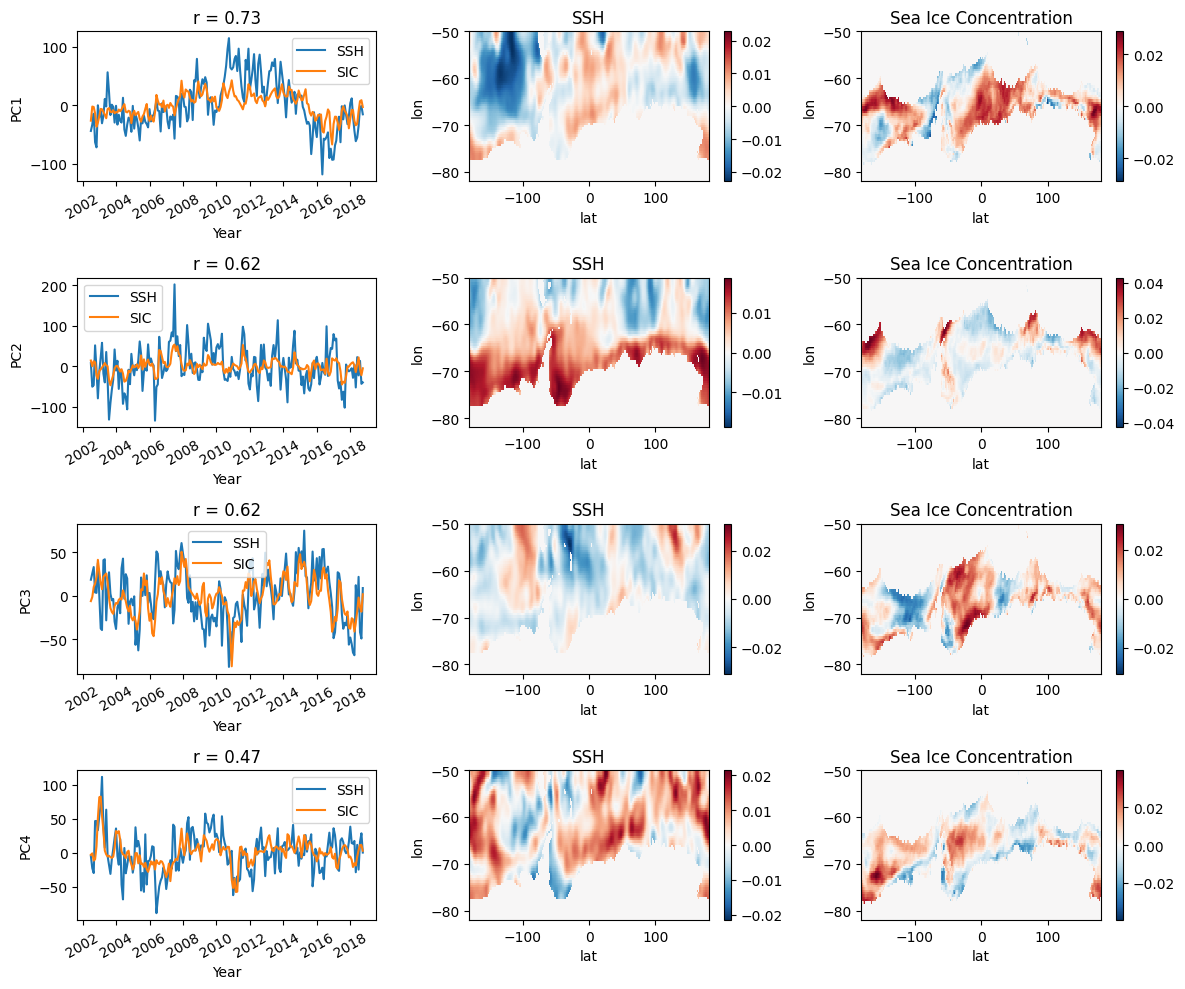

In [156]:
fig = plt.figure(figsize=(12,10))

for i in range(0,4):
    j = 3*i+1 # a = 2*(i+1) + i - 1
    
    plt.subplot(4,3,j)
    scores1.sel(mode=i+1).plot(label = 'SSH')
    scores2.sel(mode=i+1).plot(label = 'SIC')
    plt.title('r = ' +str(r_spear[i]))
    plt.xlabel('Year'); plt.ylabel('PC'+str(int(i+1)))
    plt.xticks(rotation=30) 
    plt.legend()
    
    plt.subplot(4,3,j+1)
    comps1.sel(mode=i+1).plot()
    plt.title('SSH')
    
    plt.subplot(4,3,j+2)
    comps2.sel(mode=i+1).plot()
    plt.title('Sea Ice Concentration')

fig.tight_layout()

#fig.savefig(path + 'results/MCA_output_' + gridtype + '_seas.png')

In [157]:

# compute squared covariance fraction (equivalent to explained variance in PCA)
sq_cov_frac = model.squared_covariance_fraction()
scf = sq_cov_frac.values
cum_sum = np.cumsum(scf)
print('Cumulative sum of squares:', cum_sum)
print('Squared covariance fraction:',scf)

Cumulative sum of squares: [0.27698836 0.53499744 0.67954473 0.74575853 0.78126129 0.81339203
 0.83889984 0.8614829  0.87990304 0.89702617 0.90905063 0.91949384
 0.92814071 0.93554185 0.94232145 0.94840278 0.95391061 0.95863578
 0.96285569 0.96682678 0.97050897 0.97374462]
Squared covariance fraction: [0.27698836 0.25800908 0.14454729 0.0662138  0.03550276 0.03213074
 0.02550781 0.02258306 0.01842015 0.01712313 0.01202446 0.01044321
 0.00864687 0.00740114 0.0067796  0.00608133 0.00550783 0.00472517
 0.00421991 0.00397109 0.00368219 0.00323565]


In [158]:
print(type(cum_sum))
print(len(cum_sum))
mode_percent = []
for i in range(len(cum_sum)):
    if i == 0:
        each_mode_percent =float(cum_sum[i])
        mode_percent.append(each_mode_percent)
    else:
        each_mode_percent = float(cum_sum[i]-cum_sum[i-1])
        mode_percent.append(each_mode_percent)
print('PCA fraction', mode_percent)


<class 'numpy.ndarray'>
22
PCA fraction [0.2769883634347289, 0.25800907546588725, 0.14454729380022846, 0.06621379850370146, 0.035502759412776586, 0.032130742664022494, 0.02550780531715857, 0.022583058058555427, 0.018420147695894507, 0.01712312536404559, 0.01202446061261353, 0.010443210235313583, 0.008646867634679922, 0.007401142789674631, 0.0067795983020876305, 0.006081331075016516, 0.005507828159952988, 0.004725169032993026, 0.004219909203539096, 0.003971092263903131, 0.0036821927039809577, 0.003235652104818354]
